In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-24 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Corona-Hub von www.npgeo.de](https://npgeo-corona-npgeo-de.hub.arcgis.com/)
    * [RKI COVID19](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0)
    * [CSV](https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv)
    * [Robert Koch-Institut: COVID-19-Dashboard](https://npgeo-corona-npgeo-de.hub.arcgis.com/app/478220a4c454480e823b17327b2bf1d4)
* [Priesemann-Group/covid19_inference_forecast](https://github.com/Priesemann-Group/covid19_inference_forecast/commit/4d34d342cd8e58c18b5107ce38c537d4e83bc561)
    * [data_retrieval.py](https://github.com/Priesemann-Group/covid19_inference_forecast/blob/master/covid19_inference/data_retrieval.py)

* [data source description](https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74)

In [5]:
df_   = pd.read_csv('https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data')

In [6]:
df_.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen
0,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476974,2020-03-17T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-17T00:00:00.000Z,0,1
1,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476975,2020-03-18T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-16T00:00:00.000Z,0,1
2,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476976,2020-03-18T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-18T00:00:00.000Z,0,1
3,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476977,2020-03-19T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-07T00:00:00.000Z,0,1
4,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476978,2020-03-19T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-13T00:00:00.000Z,0,1


In [7]:
df_['AnzahlFall'].sum()

150316

In [8]:
lds = df_['Bundesland']
len(lds.unique()), lds.unique()

(16,
 array(['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Nordrhein-Westfalen', 'Bremen', 'Hessen', 'Rheinland-Pfalz', 'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 'Thüringen', 'Sachsen-Anhalt'], dtype=object))

In [9]:
def timeline(in_df, state=None, county=None, time_anchor_column_name='Refdatum', count_column_name='AnzahlFall'):
    ldf = in_df.copy()
    if state is not None:
        ldf = ldf[ldf['Bundesland'] == state].copy()
    if county is not None:
        ldf = ldf[ldf['Landkreis'] == county].copy()
    ldf[time_anchor_column_name] = pd.to_datetime(ldf[time_anchor_column_name]).dt.tz_localize(None)
    ldf = ldf.set_index(time_anchor_column_name)
    ldf.index.name = 'index'
    lds = ldf[count_column_name].resample('D').sum()
    return lds

In [10]:
def create_rki_df(in_df, state=None, county=None, time_anchor_column_name='Meldedatum'):
    lds_confirmed = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlFall')
    lds_recovered = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlGenesen')
    lds_death     = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlTodesfall')
    ldf = pd.DataFrame()
    ldf['confirmed'] = lds_confirmed.cumsum()
    ldf['recovered'] = lds_recovered.cumsum()
    ldf['death']     = lds_death.cumsum()
    
    ldf['new_confirmed'] = lds_confirmed
    ldf['new_recovered'] = lds_recovered
    ldf['new_death']     = lds_death
    return ldf

In [11]:
# create_rki_df(df_)

In [12]:
cbr_germany = covid19.CasesByRegion('Germany', df=create_rki_df(df_))
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-19,143386,106178,5227,1373,152,26
2020-04-20,145097,106353,5265,1711,175,38
2020-04-21,147220,106518,5293,2123,165,28
2020-04-22,149456,106616,5316,2236,98,23
2020-04-23,150316,106658,5318,860,42,2


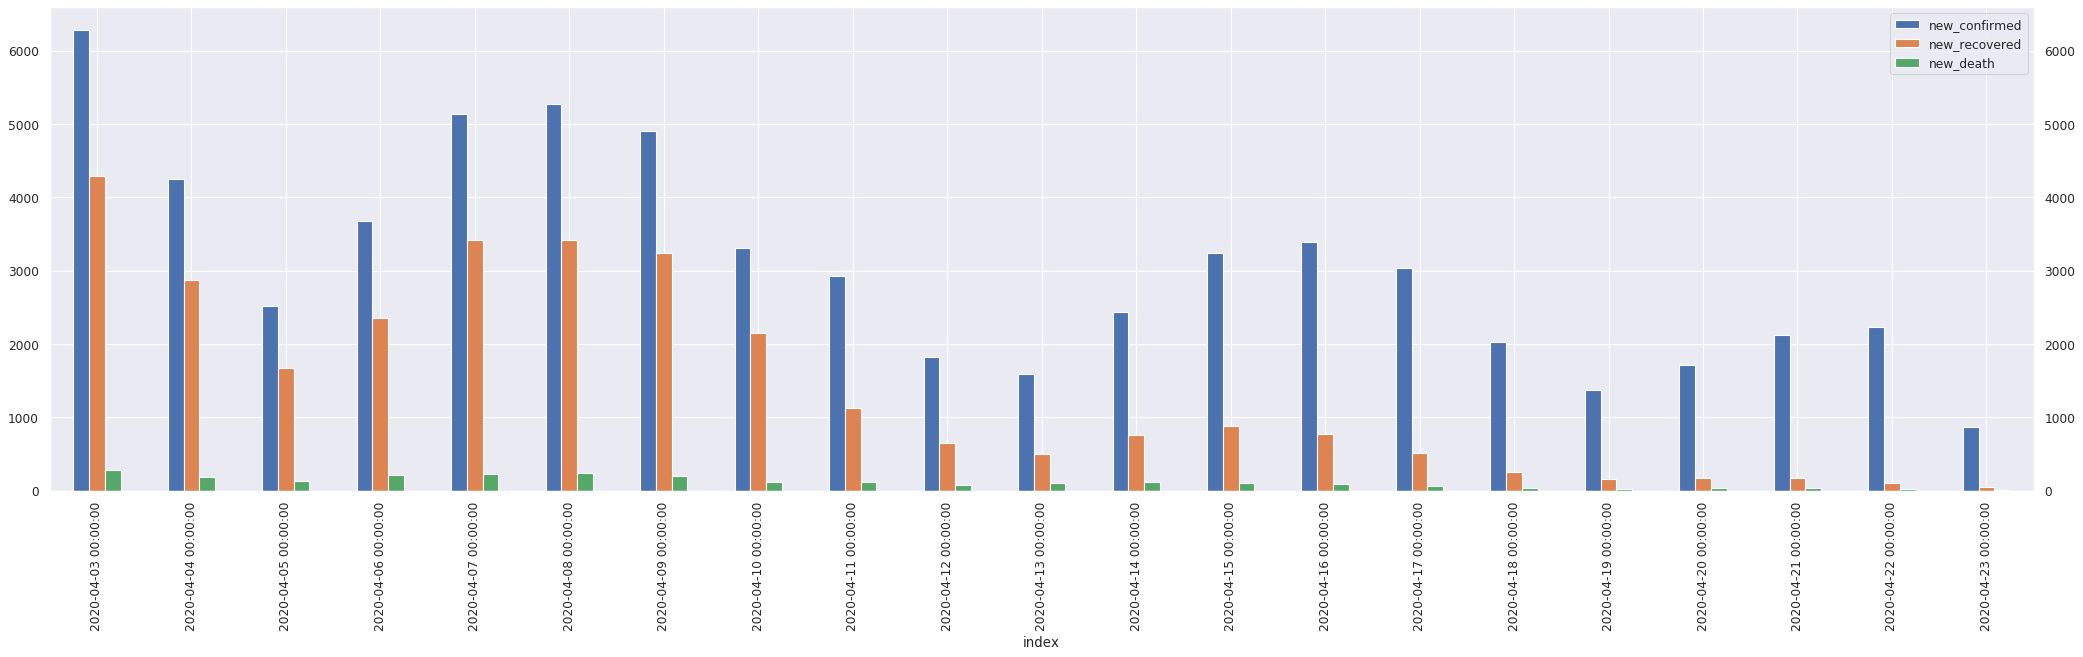

In [13]:
cbr_germany.plot_daily_stats()

sigmoid+linear 2020-06-01 00:00:00 [101246.53930034      0.18403068    -11.20096323  10676.75214898] 0.014097659602768875 1964.8500041206971


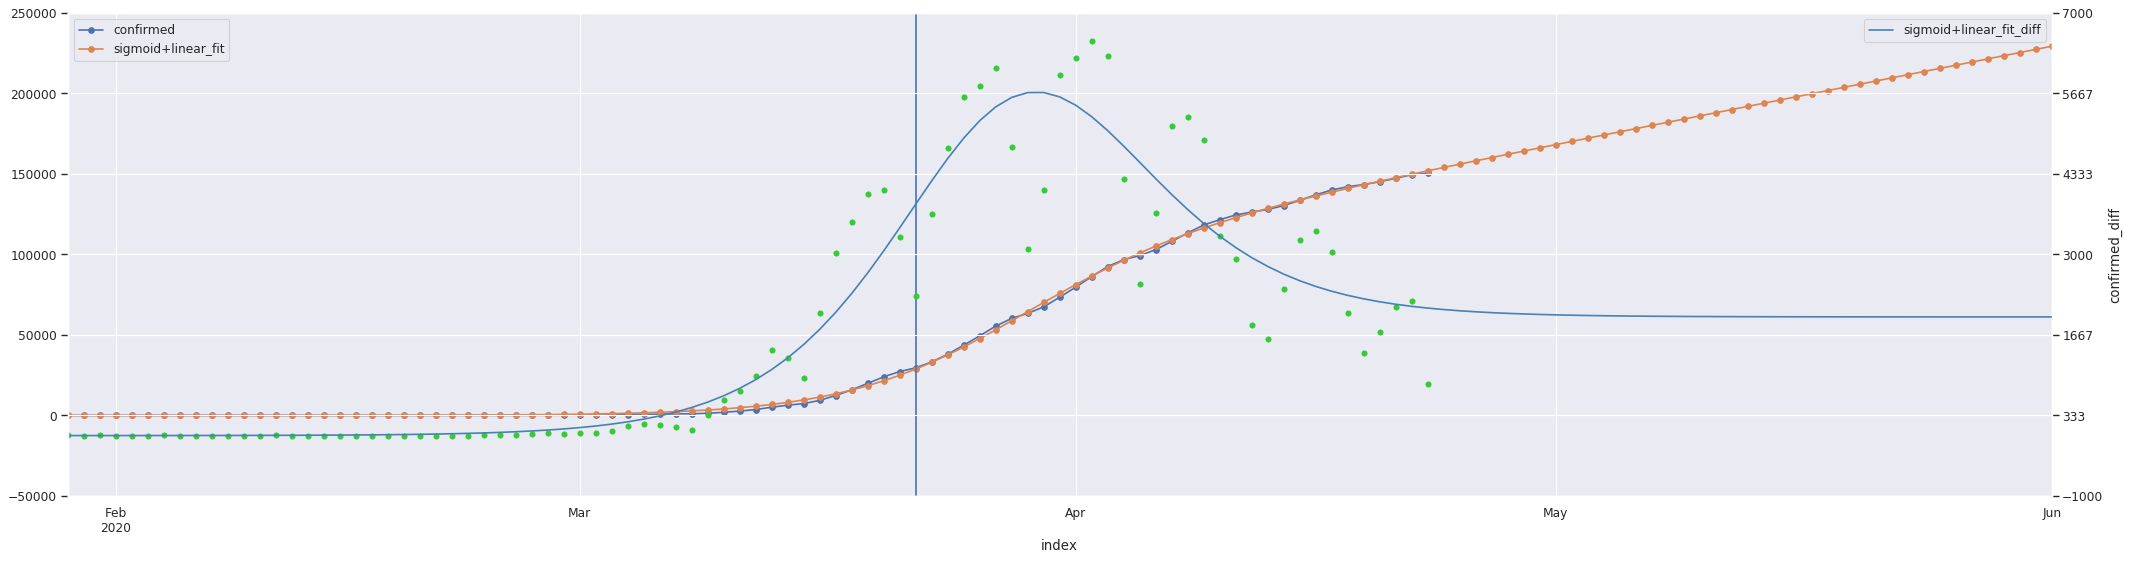

In [14]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_germany.df, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [15]:
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff
index,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0
2020-01-29,2.0,4.0,2.209240,0.371345,2.0
2020-01-30,3.0,4.0,2.655612,0.446373,0.0
2020-01-31,4.0,8.0,3.192171,0.536559,4.0
2020-02-01,5.0,8.0,3.837137,0.644966,0.0
...,...,...,...,...,...
2020-05-28,122.0,NaN,221367.154451,1965.087843,NaN
2020-05-29,123.0,NaN,223332.202316,1965.047866,NaN
2020-05-30,124.0,NaN,225297.216924,1965.014608,NaN


In [16]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid+linear_fit_diff
max,5680.268541


In [17]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

860.0

In [18]:
ldf.tail()

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff
index,,,,,
2020-05-28,122.0,NaN,221367.154451,1965.087843,NaN
2020-05-29,123.0,NaN,223332.202316,1965.047866,NaN
2020-05-30,124.0,NaN,225297.216924,1965.014608,NaN
2020-05-31,125.0,NaN,227262.203865,1964.986940,NaN
2020-06-01,126.0,NaN,229227.167788,1964.963923,NaN


In [19]:
lpopt

array([101246.53930034,      0.18403068,    -11.20096323,  10676.75214898])

In [20]:
def discrete_diff(in_da, first_value=np.nan):
    in_da = np.array(in_da)
    return np.concatenate([np.array([first_value]), in_da[1:] - in_da[:-1]])

In [21]:
lda = covid19.fitSig(ldf.x, *lpopt[:-1]).values
ldf['pure_sig_fit'] = lda
ldf['pure_sig_fit_diff'] = discrete_diff(lda)
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff
index,,,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0,1.662570,NaN
2020-01-29,2.0,4.0,2.209240,0.371345,2.0,1.998491,0.335920
2020-01-30,3.0,4.0,2.655612,0.446373,0.0,2.402281,0.403791
2020-01-31,4.0,8.0,3.192171,0.536559,4.0,2.887655,0.485374
2020-02-01,5.0,8.0,3.837137,0.644966,0.0,3.471094,0.583439
...,...,...,...,...,...,...,...
2020-05-28,122.0,NaN,221367.154451,1965.087843,NaN,101245.223401,0.265877
2020-05-29,123.0,NaN,223332.202316,1965.047866,NaN,101245.444588,0.221187
2020-05-30,124.0,NaN,225297.216924,1965.014608,NaN,101245.628596,0.184008


In [22]:
ldf['pure_sig_fit_diff'].describe()

count     125.000000
mean      809.953972
std      1368.516016
min         0.127348
25%         3.495093
50%        57.729627
75%       940.818589
max      4649.608065
Name: pure_sig_fit_diff, dtype: float64

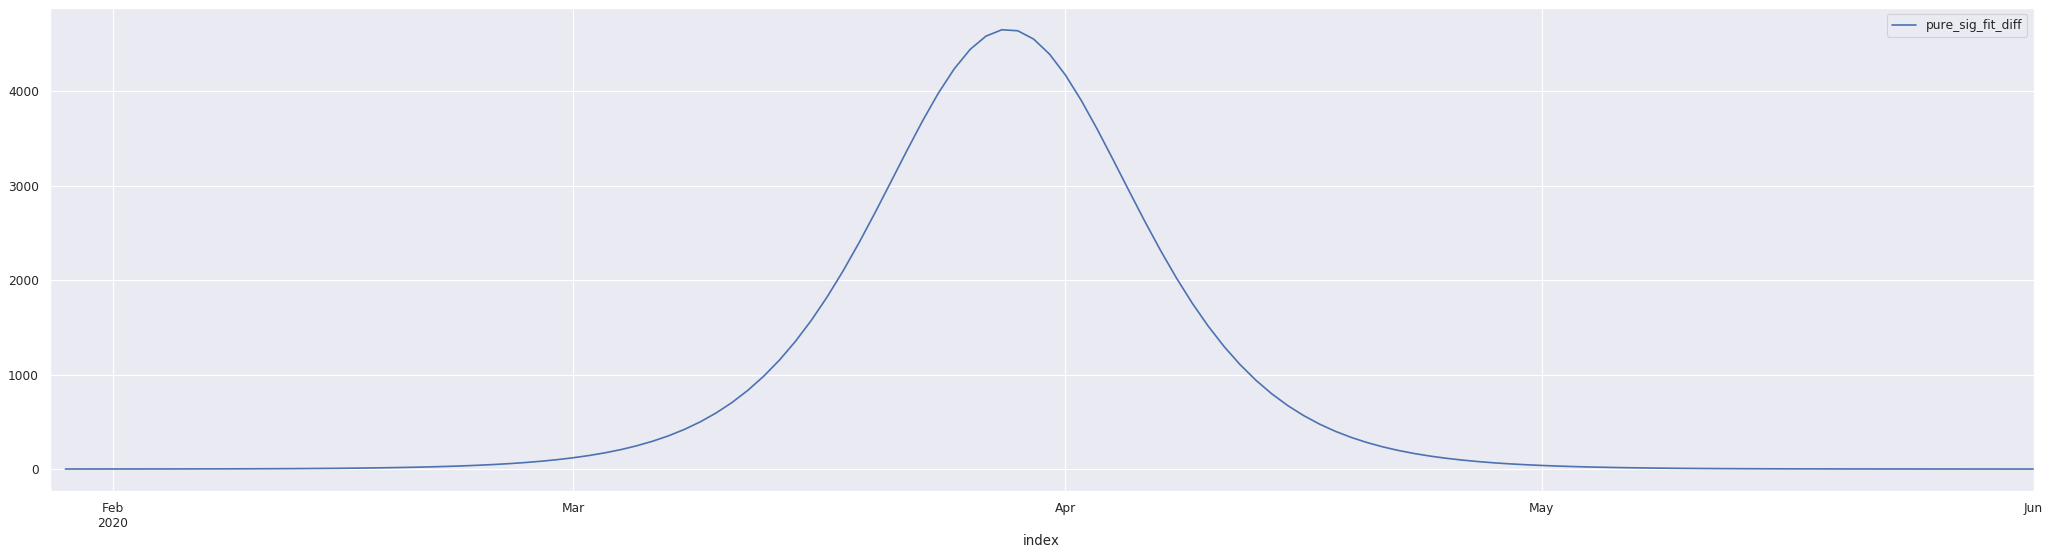

In [23]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['pure_sig_fit_diff']].plot(ax=ax)

In [24]:
def calculate_R_from_fit_diff(in_df, fit_diff_column_name):
    rdf = pd.DataFrame(index=in_df.index)
    
    average_infectious_period = 7.0
    gamma = 1 / average_infectious_period
    ws = 7
    rdf['v'] = in_df[fit_diff_column_name]
    rdf['I_t'] = in_df[fit_diff_column_name].rolling(window=ws).sum()#, min_periods=1
    lds = rdf['I_t']
    lda_delta_It = lds.values[1:] - lds.values[:-1]
    lda_gr_It = lda_delta_It / lds.values[:-1]
    lda_gr_It = np.concatenate([np.array([np.nan]), lda_gr_It])
    rdf['gr_It'] = lda_gr_It
    lda_R = np.maximum(1.0 + 1/gamma * lda_gr_It,0.0)
    rdf['R_t'] = lda_R
    return rdf

R_t    0.0
Name: 2020-04-23 00:00:00, dtype: float64

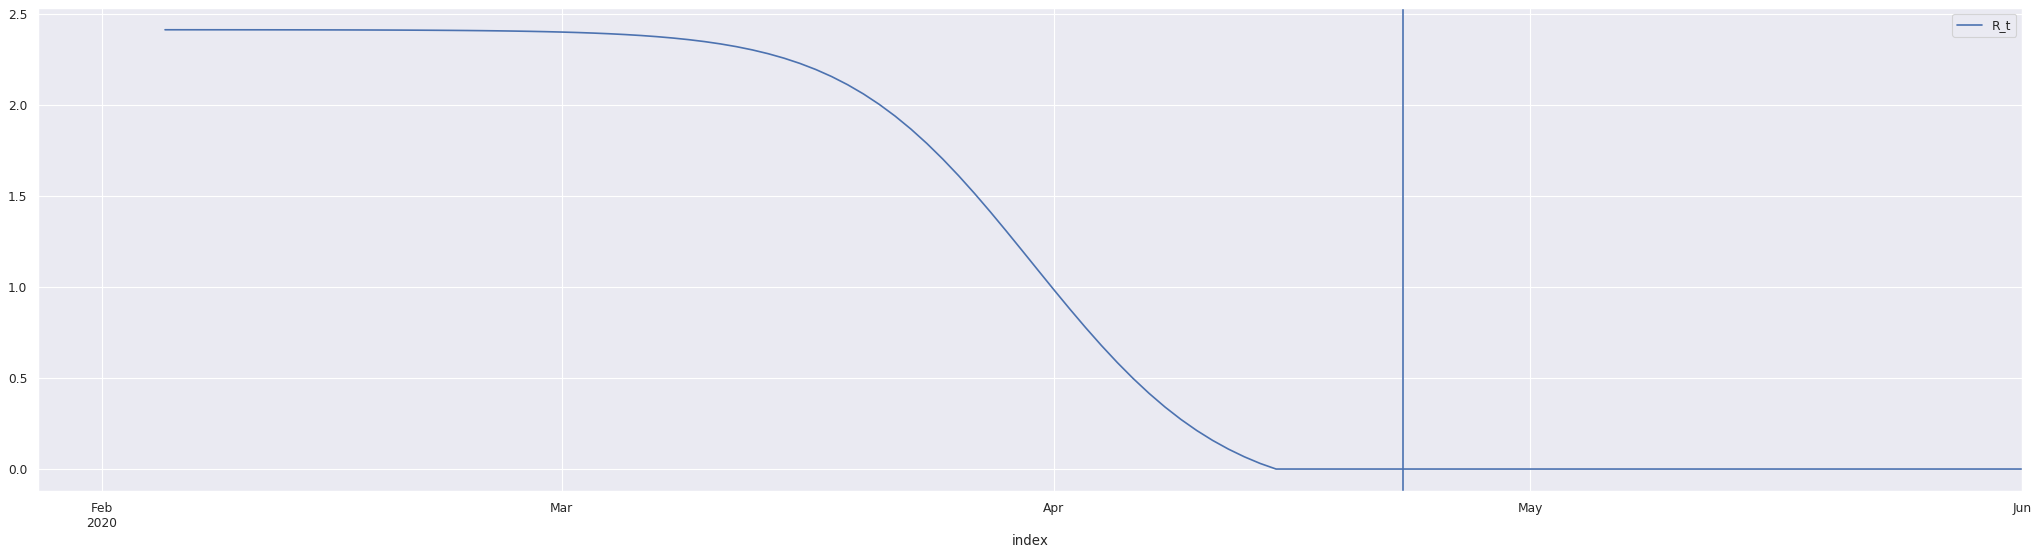

In [25]:
# ldf_R = calculate_R_from_fit_diff(ldf, label + '_fit_diff')
ldf_R = calculate_R_from_fit_diff(ldf, 'pure_sig_fit_diff')
# ldf_R_pure_sig_fit_diff.iloc[-20:]

fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R[['R_t']].plot(ax=ax)
dt = cbr_germany.df.index[-1]
ax.axvline(dt);
ldf_R[['R_t']].loc[dt]

In [26]:
# ldf_R_pure_sig_fit_diff.to_excel('ldf_R_pure_sig_fit_diff.xlsx')

In [27]:
# average_infectious_period = 7.0
# gamma = 1 / average_infectious_period
# ws = 7
# ldf['I_t'] = ldf[label + '_fit_diff'] .rolling(window=ws).sum()#, min_periods=1
# lds = ldf['I_t']
# delta_It = lds.values[1:] - lds.values[:-1]
# gr_It = delta_It / lds.values[:-1]
# gr_It = np.concatenate([np.array([np.nan]), gr_It])
# ldf['gr_It'] = gr_It
# R = 1.0 + 1/gamma * gr_It
# ldf['R_t'] = R

In [28]:
ldf.tail()

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff
index,,,,,,,
2020-05-28,122.0,NaN,221367.154451,1965.087843,NaN,101245.223401,0.265877
2020-05-29,123.0,NaN,223332.202316,1965.047866,NaN,101245.444588,0.221187
2020-05-30,124.0,NaN,225297.216924,1965.014608,NaN,101245.628596,0.184008
2020-05-31,125.0,NaN,227262.203865,1964.986940,NaN,101245.781675,0.153079
2020-06-01,126.0,NaN,229227.167788,1964.963923,NaN,101245.909023,0.127348


In [29]:
import GPy, IPython.display

In [30]:
ldf1 = ldf.loc[:cbr_germany.df.index[-2]]
ldf1.tail()

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff
index,,,,,,,
2020-04-18,82.0,142013.0,140961.080213,2321.908722,2025.0,99217.104085,400.212699
2020-04-19,83.0,143386.0,143225.316193,2264.235979,1373.0,99552.523688,335.419603
2020-04-20,84.0,145097.0,145440.868503,2215.552310,1711.0,99833.295685,280.771997
2020-04-21,85.0,147220.0,147615.425279,2174.556776,2123.0,100068.082435,234.786750
2020-04-22,86.0,149456.0,149755.530662,2140.105384,2236.0,100264.247092,196.164656


In [87]:
k1 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=7.)
# k2_exp_sine_squred_gamma= 2.0 / 1.3 ** 2.0
# k2_exp_sine_squred_period = 7.0
# k2 = GPy.kern.RBF(input_dim=1, variance=(2.4 ** 2.0), lengthscale=30.0) * GPy.kern.PeriodicExponential(input_dim=1, period=k2_exp_sine_squred_period, variance=1.0,  lengthscale=1.0/k2_exp_sine_squred_gamma)
# k2 = GPy.kern.PeriodicExponential(input_dim=1, period=k2_exp_sine_squred_period, variance=1.0,  lengthscale=1.0/k2_exp_sine_squred_gamma)
k2 = GPy.kern.PeriodicExponential(input_dim=1, period=7.0, variance=1.0,  lengthscale=1.0)
k3 = GPy.kern.RBF(1, variance=(0.18 ** 2), lengthscale=1.0) + GPy.kern.White(1, variance=0.19)
# kernel = k1 + k2 + k3
kernel = k1 + k2 # + k2 # + k3

In [88]:
X = ldf1.x.values.reshape(-1,1)
Y = (ldf1.confirmed - ldf1[label + '_fit']  ).values.reshape(-1,1)
m = GPy.models.GPRegression(X,Y,kernel)
m

GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,7.0,+ve,
sum.periodic_exponential.variance,1.0,+ve,
sum.periodic_exponential.lengthscale,1.0,+ve,
sum.periodic_exponential.period,7.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [89]:
m.optimize_restarts(num_restarts = 10, robust=True)

Warning - optimization restart 1/10 failed
Optimization restart 2/10, f = 61783.78787608347
Warning - optimization restart 3/10 failed
Warning - optimization restart 4/10 failed
Optimization restart 5/10, f = 737.3676136516299
Warning - optimization restart 6/10 failed
Optimization restart 7/10, f = 169786.59650601947
Warning - optimization restart 8/10 failed
Optimization restart 9/10, f = 19578.321332077365
Optimization restart 10/10, f = 399717.46936517674


GP_regression.,value,constraints,priors
sum.rbf.variance,280.4943559998898,+ve,
sum.rbf.lengthscale,1.3102278835635301,+ve,
sum.periodic_exponential.variance,3.8749578563775375,+ve,
sum.periodic_exponential.lengthscale,0.9526098865477799,+ve,
sum.periodic_exponential.period,26.60285618865638,+ve,
Gaussian_noise.variance,133.1191097235946,+ve,


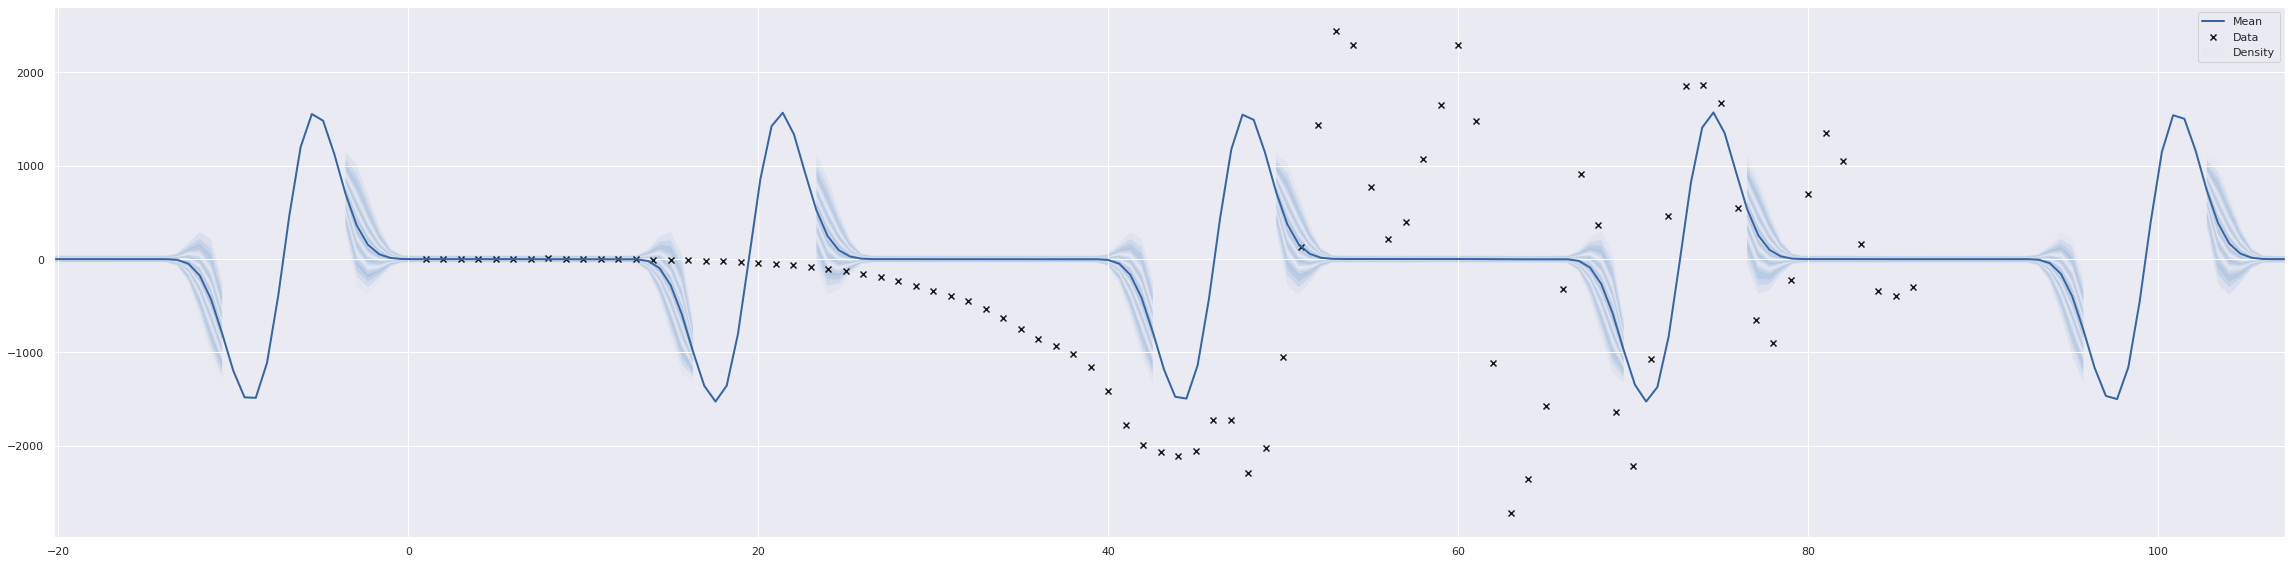

In [90]:
display(m)
fig = m.plot(plot_density=True, figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
#GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [35]:
ldf['gp_fit'] = m.predict(ldf.x.values.reshape(-1,1))[0].reshape(-1)
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff,gp_fit
index,,,,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0,1.662570,NaN,-52.205415
2020-01-29,2.0,4.0,2.209240,0.371345,2.0,1.998491,0.335920,-40.530157
2020-01-30,3.0,4.0,2.655612,0.446373,0.0,2.402281,0.403791,-21.063163
2020-01-31,4.0,8.0,3.192171,0.536559,4.0,2.887655,0.485374,2.560149
2020-02-01,5.0,8.0,3.837137,0.644966,0.0,3.471094,0.583439,26.953075
...,...,...,...,...,...,...,...,...
2020-05-28,122.0,NaN,221367.154451,1965.087843,NaN,101245.223401,0.265877,61419.075606
2020-05-29,123.0,NaN,223332.202316,1965.047866,NaN,101245.444588,0.221187,56676.432642
2020-05-30,124.0,NaN,225297.216924,1965.014608,NaN,101245.628596,0.184008,52119.769690


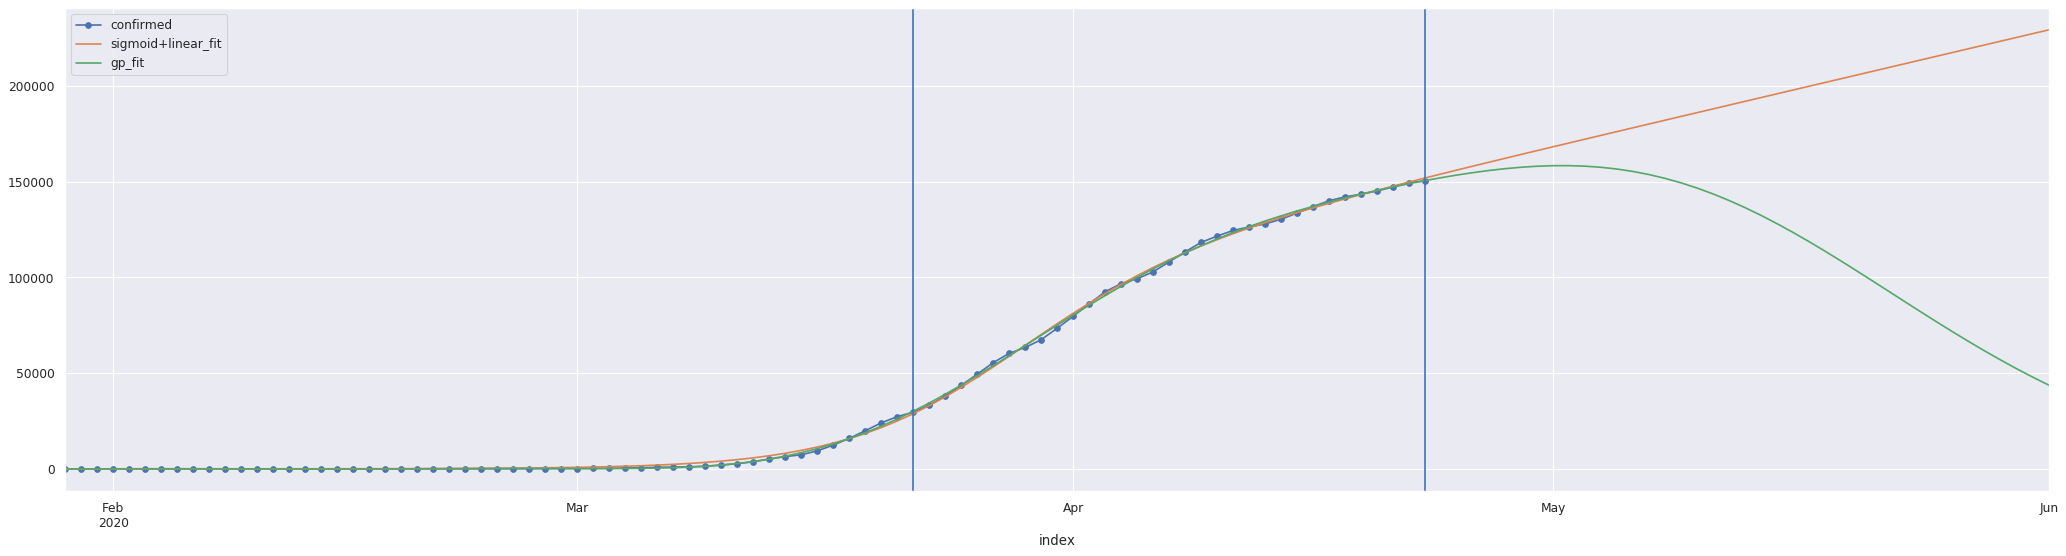

In [42]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ldf[[label + '_fit', 'gp_fit']].iloc[1:,:].plot(ax=ax);
ax.axvline(restriction_start_date);
dt = cbr_germany.df.index[-1]
ax.axvline(dt);

In [37]:
import filterpy, filterpy.kalman
filterpy.__version__

'1.4.5'

In [38]:
kf = filterpy.kalman.KalmanFilter(dim_x=1, dim_z=1)